# Estimation and filtering

This assignment is about **regime change detection**. Let us consider two
independent Poisson processes $N_a$ and $N_b$ of intensity a and b respectively. Initially we observe only $N_a$ and after a random time τ independent of $N_a$ and $N_b$, we observe $N_b$. 

This is equivalent to saying that we observe a point process $N$ whose intensity undergoes an abrupt change: there is a random time $\tau$ such that $\lambda(t) = a + (b - a)Z(t^{-})$ with $Z(t) = \mathcal{1}_{\{\tau \leq t \}}$
We want to try to estimate $\tau$ through the observation of jump instances of $N$.

In [1]:
from scipy.stats import expon
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

Let $\tau$ be a random variable that follows an exponential law of parameter $\mu = 0.2$ with distribution function $F$ and density $f$.

In [2]:
# Parameter initialization

mu = 0.2
tau = expon.rvs(scale=1/mu)
a = 5
b = 10
print('Here, tau is :',tau)

Here, tau is : 5.436522773380731


### Computation of the filter function

Let's have: 
$h(s) = \frac{f(s)}{1-F(s)}$

$\tau$ follows an exponential law of parameter $\mu$.

Therefore: 
$f(s) = \mu.\exp(-\mu.x)$ and $F(s) = 1 - \exp(-\mu.x)$

Finally, 
$h(s) = \mu$

In [3]:
def h(x):
    return expon.pdf(x,scale=1/mu)/(1-expon.cdf(x,scale=1/mu))

#### Rounding error

In [4]:
print('h(2) computed is :', h(2))
print('h(2) theoretical is :', mu)

h(2) computed is : 0.19999999999999998
h(2) theoretical is : 0.2


I notice that there is a rounding error when I calculate the function h from its definition formula. Therefore, I decide to use the theoretical formula of h in this case where it is exactly equal to $\mu$ in order to avoid the propagation of errors.

# Example of a draw from an exponential law

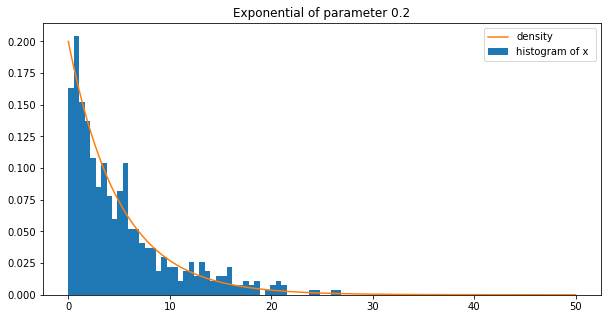

In [5]:
n=500

# sample of exponential variables of parameter 0.2
x=expon.rvs(scale=1/mu,size=n)
x.mean()
x.var()

# curve and histogram plot
plt.figure(figsize=(10,5))
plt.title('Exponential of parameter 0.2')
plt.hist(x, 50, density=True)
tt=np.linspace(0.0, 50,200)
plt.plot(tt,mu*np.exp(-mu*tt))
plt.legend(['density', 'histogram of x '])
plt.show()

# Simulation of a trajectory of N on the time interval [0,10]

In [6]:
def poissonProcess(a, b, tau,t0 = 0, T = 10):
    
    # initialization 
    t = t0
    n = 0
    jumpInstances = [0]
    N = [0]
    
    # the drawing continues as long as it does not exceed the study interval
    while(t<=T):
        
        # Na observation
        while(t<=min(tau,T)):
            x = expon.rvs(scale=1/a)
            t += x
            n +=1
            jumpInstances.append(t)
            N.append(n)
            # keep the row where it goes from process a to process b
            changeRank = n-1
            
        # observation de Nb
        x = expon.rvs(scale=1/b)
        t += x
        n +=1 
        jumpInstances.append(t)
        N.append(n)
    return jumpInstances, N, changeRank

In [7]:
T, N, changeRank = poissonProcess(a,b,tau)

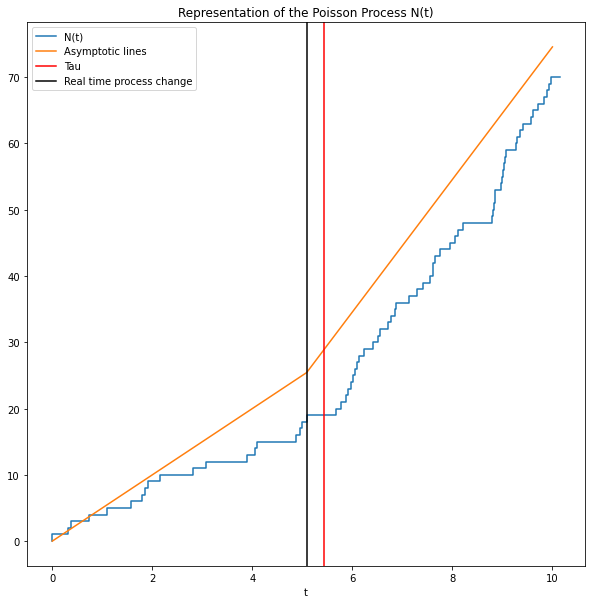

In [8]:
x = np.linspace(0,10,len((N)))

plt.figure(figsize=(10,10))
plt.title('Representation of the Poisson Process N(t)')
plt.step(T, N, label = 'N(t)')
plt.plot([0,T[changeRank],10],[0,T[changeRank]*5,100-T[changeRank]*5], label = 'Asymptotic lines')
plt.axvline(x=tau,color='red', label = 'Tau')
plt.axvline(x=T[changeRank],color='black', label = 'Real time process change')
plt.xlabel("t")
plt.legend()
plt.show()

#  $\tilde{Z}$ representation

Let's $Z(t) = \mathbb{1}_{\{\tau<=t\}}$
and $\tilde{Z}(t) = Z(t) -  \int_{0}^{\infty} h(s).\mathbb{1}_{[0,{\tau}\wedge{t}]} \, \mathrm{d}s $

Finally, $\tilde{Z}(t) = Z(t) - \mu.({\tau}\wedge{t})$

In [9]:
def Z(t):
    return 1*(tau<=t)

In [10]:
def Z_tilde(t):
    return Z(t)-mu*(tau*(tau<=t)+t*(t<tau))

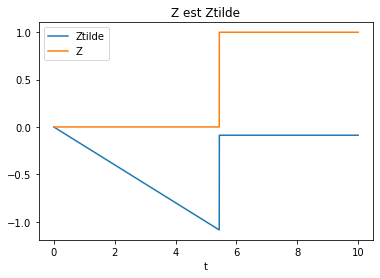

In [11]:
x = np.linspace(0,10,10000)
y = Z_tilde(x)
z = Z(x)

plt.title('Z est Ztilde')
plt.plot(x,y, label = 'Ztilde')
plt.plot(x,z, label ='Z')
plt.xlabel("t")
plt.legend()
plt.show()

From the definition of $Z(t)$ and $\tilde{Z}(t)$, it is obvious that $\tau$ is the time at which both functions have a jump.

### Relative error

In [12]:
def findJump(t,fonc):
    for i in range(1,len(t)):
        if abs(fonc(t[i])-fonc(t[i-1]))>=1/2:
            return t[i]

In [13]:
tau_graphique = findJump(x,Z_tilde)

In [14]:
def relative_error(valeur, valeur_computed):
    # if the value of tau cannot be found with one of the methods
    # the default value 200 is assigned.
    if(valeur_computed == None): 
        return 200
    return 100 * abs(valeur-valeur_computed)/valeur

In [15]:
print("The relative error between the graphical tau and the true tau is (in percent) : ", relative_error(tau,tau_graphique))

The relative error between the graphical tau and the true tau is (in percent) :  0.00038408713760941943


The relative error is very small (less than 0.01%), which is normal because $\tilde{Z}(t)$ has $\tau$ as jump time. The general idea is to do the same reasoning with a function that does not depend explicitly on $\tau$. This is why we define $\hat{Z}$

#  $\hat{Z}$ representation

Let's considerate the following processus $t \mapsto \hat{Z}(t) = \mathbb{E}[Z(t) | \mathcal{F}_{t}^{N}]$ with $ \mathcal{F}_{t}^{N} = \sigma(N(s),s\leq t)$

From an exercise in the handout, we can show that : 

$\forall t \in [T_ {n},T_{n+1}]$  
$\hat{Z}(t) = \hat{Z}(T_{n}) + \int_{T_{n}}^{t} (h(s)-(b-a)\hat{Z}(s))(1-\hat{Z}(s)) \, \mathrm{d}s$

And that at the time of the n-th jump, the amplitude is given by : 
$\hat{Z}(T_{n}) - \hat{Z}(T_{n}^{-}) = \frac{(b-a)\hat{Z}(T_{n}^{-})(1-\hat{Z}(T_{n}^{-}))}{a + (b-a)\hat{Z}(T_{n}^{-})}$

On each interval $[T_{n-1},T_{n}]$ follows the differential equation 
$y'(t) = f(t,y(t)) = (h(t)-(b-a)y(t))(1-y(t))$
with the condition: $y(T_{n-1})=\hat{Z}(T_{n-1})$

In [16]:
def f(y,t):
    return (mu-(b-a)*y)*(1-y)

In [17]:
n_points = 10000

In [18]:
def buildZ_chapeau(T, n = n_points, a = 5, b = 10):
    t = np.linspace(T[0],T[1],n,endpoint = False)
    x = t
    Z_chapeau = odeint(f,T[0],t).reshape(-1)
    Z_chapeau_aux_instants_de_sauts = [0]
    for i in range(1,len(T)-1):
        Z_saut = Z_chapeau[-1] + (b-a)*Z_chapeau[-1]*(1-Z_chapeau[-1])/(a+(b-a)*Z_chapeau[-1])  
        Z_chapeau_aux_instants_de_sauts.append(Z_saut)
        t = np.linspace(T[i],T[i+1],n,endpoint = False)
        x = np.concatenate((x,t))
        Z_chapeau = np.concatenate((Z_chapeau,odeint(f,Z_saut,t).reshape(-1)))
    Z_chapeau_aux_instants_de_sauts.append(Z_chapeau[-1])
    return x, Z_chapeau, Z_chapeau_aux_instants_de_sauts

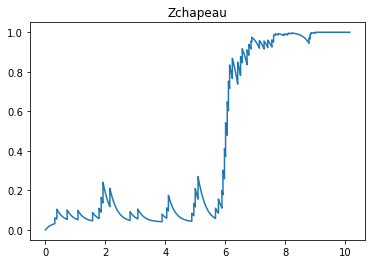

In [19]:
x, Z_chapeau, Z_chapeau_aux_instants_de_sauts = buildZ_chapeau(T, n = n_points, a = 5, b = 10)

plt.title("Zchapeau")
plt.plot(x,Z_chapeau)
plt.show()

In [20]:
t = np.linspace(T[0],T[1],n_points,endpoint = False)
sol = solve_ivp(lambda t, y: f(y,t), [T[0], T[1]], [0],t_eval = t)
Z_chapeau = np.array(sol.y[0])
for i in range(1, len(T)-1):
    new_t = np.linspace(T[i],T[i+1],n_points,endpoint = False)
    t = np.concatenate((t,new_t))
    sol = solve_ivp(lambda t, y: f(y,t), [T[i], T[i+1]], [Z_chapeau[-1]],t_eval = new_t)
    Z_chapeau = np.concatenate((Z_chapeau,sol.y[0]))
    Z_chapeau[-1]= Z_chapeau[-1] + (b-a)*Z_chapeau[-1]*(1-Z_chapeau[-1])/(a+(b-a)*Z_chapeau[-1]) 

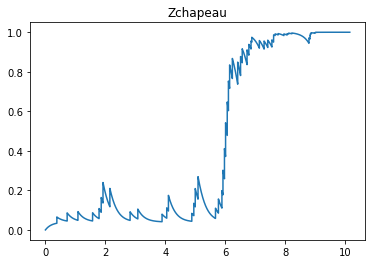

In [21]:
plt.title("Zchapeau")
plt.plot(t,Z_chapeau)
plt.show()

I notice that both functions odeint and solve_ivp return the same result so I will use odeint in the following.

### Tau research

In [22]:
def findTau(Z):
    return x[np.where(Z>=0.5)[0][0]]

In [23]:
tau_found = findTau(Z_chapeau)

In [24]:
print("The relative error between the found tau and the true tau is (in percent) : ", relative_error(tau,tau_found))

The relative error between the found tau and the true tau is (in percent) :  10.435979805395789


In [25]:
def findTau_ecart(Z,Z_chapeau_aux_instants_de_sauts,t,ecart,bande):
    test = 0 
    for i in range(len(Z_chapeau_aux_instants_de_sauts)-bande):
        if(ecart < abs(Z_chapeau_aux_instants_de_sauts[i]-Z_chapeau_aux_instants_de_sauts[i+bande])):
            return t[i+bande//2]       

In [26]:
tau_found2 = findTau_ecart(Z_chapeau,Z_chapeau_aux_instants_de_sauts,T,0.4,20)

In [27]:
print("The relative error between the found tau and the true tau is (in percent) ", relative_error(tau,tau_found2))

The relative error between the found tau and the true tau is (in percent)  24.594233725111323


In [28]:
def findTau_petitSaut(Z):
    a = np.where(Z>=0.1)[0][0]
    b = np.where(Z>=0.3)[0][0]
    return (x[a]+x[b])/2

In [29]:
tau_found2 = findTau_petitSaut(Z_chapeau)
tau_found2,tau

(3.852101814999597, 5.436522773380731)

In [30]:
print("The relative error between the found tau and the true tau is (in percent) ", relative_error(tau,tau_found2))

The relative error between the found tau and the true tau is (in percent)  29.14401400356598


Here, one can see that method 1 gives the best result for tau, it allows to find a good approximation at first for tau. The two other methods that I implemented give results that are quite interesting and that I will highlight in the following tests. In this case, one can see that my method 2 which looks on a slice of 20 instants at the moment when we have a jump of 0.4 and which returns the middle of this band even gives a result with a relative error of about 24%, which is interesting.

### KMEANS

In [31]:
# I remove the first element of the jump times which is the initialization to 0
T = T[1:]

One of the difficulties of this part is to use the data in order to highlight a specific characteristic of the process a or the process b which will be used to make the two clusters. I thought of studying $\frac{N(t)}{t}$ which tends to the intensity of the Poisson process. I create a new representation of the data with the first component which is the difference between $\frac{N(T_{n})}{T_{n}}$ and $\frac{N(T_{n-1})}{T_{n-1}}$ in order to highlight the moments where the slope of the process changes. The second component to see if the slope of the process is rather equal to a and the third if it is rather equal to b.

In [32]:
def createData(T, a = 5, b = 10):
    data = [[1/(T[0]),(1-a*T[0])/T[0],(1-b*T[0])/T[0]-a]]
    for i in range(1,len(T)):
         data.append([abs((i+1)/(T[i])-(i)/T[i-1]),(i+1-a*T[i])/T[i],(i+1-b*T[i])/T[i]-a])
    return np.asarray(data)

In [33]:
# Creation of data for the k-means
data = createData(T)
# Creation of labels to measure the accuracy of k-means
labels = np.concatenate((0*data[:changeRank,0],0*data[changeRank:,0]+1))

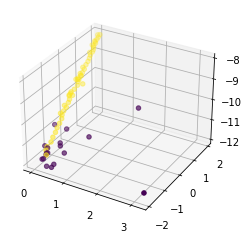

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# The color of the points depends on their label
ax.scatter(data[:,0], data[:,1], data[:,2], c=labels)
plt.show()

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++').fit(data)

In [36]:
pred = kmeans.predict(data)
print(kmeans.labels_)
from sklearn import metrics
metrics.adjusted_rand_score(pred, labels)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


0.3169609661126247

In [37]:
#Normally, if my kmeans is well implemented the max between p.where(pred==0)[0][0]
# and np.where(pred==1)[0][0] gives the rank following the process change rank
#rankchangefound = max(np.where(pred==0)[0][0],np.where(pred==1)[0][0])-1

# Finally, I realized that sometimes some instants were badly labeled and so
# it found a change of rank too early.
# To smooth out this problem I preferred to take the minimum between the two integer sequences which gives me
# so n*(n+1)/2 with n the rank of changemetn and so I don't consider the bad labels.
rankchangefound = int(np.sqrt(min(np.where(pred==0)[0].sum()/2, np.where(pred==1)[0].sum()/2)))

In [38]:
# I take the average time between the time of the last element a found and the first element b found.
Tau_kmeans = (T[rankchangefound]+T[rankchangefound+1])*0.5

In [39]:
print("The relative error between the found tau and the true tau is (in percent) : ", relative_error(tau,Tau_kmeans))

The relative error between the found tau and the true tau is (in percent) :  8.59642960838785


In [40]:
Tau_kmeans,tau

(4.969175920023082, 5.436522773380731)

By changing my way of finding the process change rank, I find very interesting results with my K-means. Indeed, when I take the rank of change from a sum and not considering the first change from label 0 to 1, I don't consider the bad labels that give a smaller $\tau$ than the true one. 

I also tried several representations of the data (for example: considering the difference between the different jump times but as the average draw is in 0.2 for the process a and in 0.1 for the process b the k-means has difficulties to differentiate them) and this one gives the best results. 

### Different tests

In [41]:
tauList = np.linspace(1,10.01,30, endpoint = False)
tauList

array([1.        , 1.30033333, 1.60066667, 1.901     , 2.20133333,
       2.50166667, 2.802     , 3.10233333, 3.40266667, 3.703     ,
       4.00333333, 4.30366667, 4.604     , 4.90433333, 5.20466667,
       5.505     , 5.80533333, 6.10566667, 6.406     , 6.70633333,
       7.00666667, 7.307     , 7.60733333, 7.90766667, 8.208     ,
       8.50833333, 8.80866667, 9.109     , 9.40933333, 9.70966667])

# Influence of tau on accuracy and other processes

In [42]:
methode1 = []
methode2 = []
methode3 = []
kmeansError = []
for tau in tauList:
    T, N, rangDeChangement = poissonProcess(a,b,tau)
    x, Z_chapeau, Z_chapeau_aux_instants_de_sauts = buildZ_chapeau(T)
    methode1.append(relative_error(tau,findTau(Z_chapeau)))
    methode2.append(relative_error(tau,findTau_ecart(Z_chapeau,Z_chapeau_aux_instants_de_sauts,T,0.4,30)))
    methode3.append(relative_error(tau,findTau_petitSaut(Z_chapeau)))
    
    data = createData(T[1:])
    labels = np.concatenate((0*data[:rangDeChangement,0],0*data[rangDeChangement:,0]+1))
    kmeans = KMeans(n_clusters=2, n_init=20, init='k-means++').fit(data)
    pred = kmeans.predict(data)
    rangchangementtrouvé = int(np.sqrt(min(np.where(pred==0)[0].sum()/2, np.where(pred==1)[0].sum()/2)))
    Tau_kmeans = (T[rangchangementtrouvé]+T[rangchangementtrouvé+1])*0.5
    kmeansError.append(relative_error(tau,Tau_kmeans))

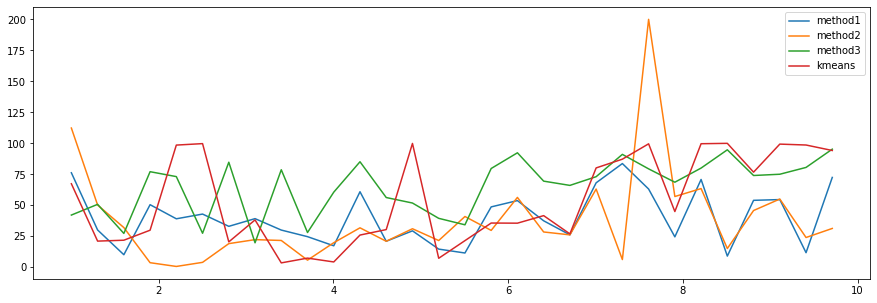

In [43]:
plt.figure(figsize=(15,5))
plt.plot(tauList,methode1, label = 'method1')
plt.plot(tauList,methode2, label = 'method2')
plt.plot(tauList,methode3, label = 'method3')
plt.plot(tauList,kmeansError, label = 'kmeans')
plt.legend()
plt.show()

I notice that the worst approximation method here is the method 3 even if its precision is sometimes quite good (relative error lower than 30%) and the methods 1 and 2 are nearly equivalent. I notice that for some values of tau method 2 gives very good results with a relative error lower than 5%. 

Concerning the k-means, one can see that sometimes it gives very good tau and even better than the other methods but it is more unstable and it oscillates between very good and bad approximation. 

# Influence of changing a and b on accuracy

In [44]:
tau =expon.rvs(scale=1/mu)
print('Ici, tau vaut :',tau)

Ici, tau vaut : 0.7595212950176483


#### small gap

In [45]:
aList = np.linspace(1,10,10)
bList = aList + 2

methode1 = []
methode2 = []
methode3 = []
kmeansError = []
for i in range(len(aList)):
    a = aList[i]
    b = bList[i]
    T, N, rangDeChangement = poissonProcess(a,b,tau)
    x, Z_chapeau, Z_chapeau_aux_instants_de_sauts = buildZ_chapeau(T, a = a, b = b)
    methode1.append(relative_error(tau,findTau(Z_chapeau)))
    methode2.append(relative_error(tau,findTau_ecart(Z_chapeau,Z_chapeau_aux_instants_de_sauts,T,0.4,30)))
    methode3.append(relative_error(tau,findTau_petitSaut(Z_chapeau)))
    
    data = createData(T[1:], a = a, b = b)
    labels = np.concatenate((0*data[:rangDeChangement,0],0*data[rangDeChangement:,0]+1))
    kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++').fit(data)
    pred = kmeans.predict(data)
    rangchangementtrouvé = int(np.sqrt(min(np.where(pred==0)[0].sum()/2, np.where(pred==1)[0].sum()/2)))
    Tau_kmeans = (T[rangchangementtrouvé]+T[rangchangementtrouvé+1])*0.5
    kmeansError.append(relative_error(tau,Tau_kmeans))

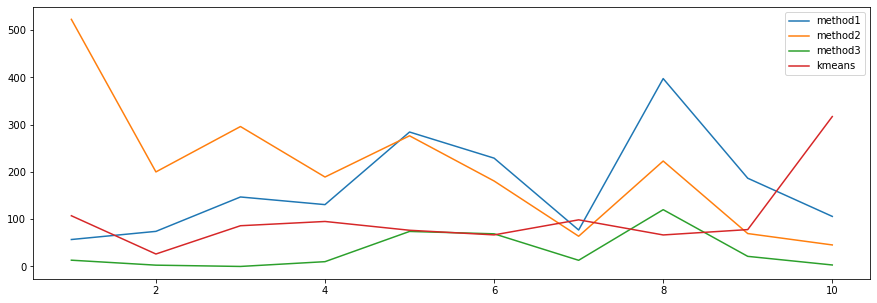

In [46]:
plt.figure(figsize=(15,5))
plt.plot(aList, methode1, label = 'method1')
plt.plot(aList, methode2, label = 'method2')
plt.plot(aList,methode3, label = 'method3')
plt.plot(aList,kmeansError, label = 'kmeans')
plt.legend()
plt.show()

I notice here that when I decrease the gap between a and b method 2 does not manage to find a tau that matches the requested constraints when a is close to 0 (by default the error is 200% when the graphical tau is not defined). Nevertheless, method 3 gives for a $\tau$ close to 0 the best approximation. Finally, I observe less oscillations on the quality of the methods and the results are more homogeneous.

#### Large gap

In [47]:
aList = np.linspace(1,10,10)
bList = aList + 5

methode1 = []
methode2 = []
methode3 = []
kmeansError = []
for i in range(len(aList)):
    a = aList[i]
    b = bList[i]
    T, N, rangDeChangement = poissonProcess(a,b,tau)
    x, Z_chapeau, Z_chapeau_aux_instants_de_sauts = buildZ_chapeau(T, a = a, b = b)
    methode1.append(relative_error(tau,findTau(Z_chapeau)))
    methode2.append(relative_error(tau,findTau_ecart(Z_chapeau,Z_chapeau_aux_instants_de_sauts,T,0.4,30)))
    methode3.append(relative_error(tau,findTau_petitSaut(Z_chapeau)))
    
    data = createData(T[1:], a = a, b = b)
    labels = np.concatenate((0*data[:rangDeChangement,0],0*data[rangDeChangement:,0]+1))
    kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++').fit(data)
    pred = kmeans.predict(data)
    rangchangementtrouvé = int(np.sqrt(min(np.where(pred==0)[0].sum()/2, np.where(pred==1)[0].sum()/2)))
    Tau_kmeans = (T[rangchangementtrouvé]+T[rangchangementtrouvé+1])*0.5
    kmeansError.append(relative_error(tau,Tau_kmeans))

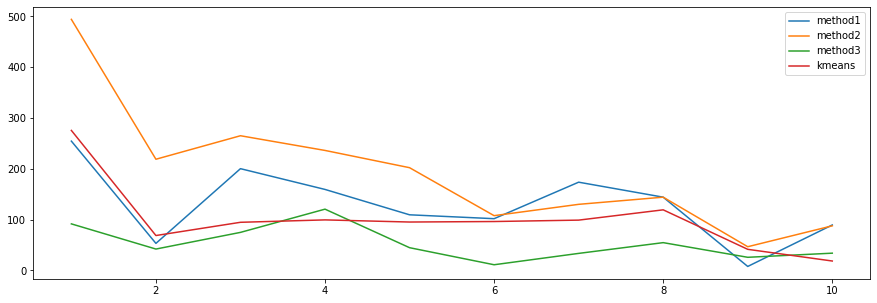

In [48]:
plt.figure(figsize=(15,5))
plt.plot(aList, methode1, label = 'method1')
plt.plot(aList, methode2, label = 'method2')
plt.plot(aList,methode3, label = 'method3')
plt.plot(aList,kmeansError, label = 'kmeans')
plt.legend()
plt.show()

When the difference between a and b is higher, I see that k-means gives better results sometimes better than method 1 and surprisingly the methods have representations of the accuracy that follow about the same pattern. Method 3 is the best here.

# Influence of a model change

In [49]:
from scipy.stats import uniform

In [50]:
uniform.rvs(0,1)

0.817101527577381

In [51]:
def uniformProcess(a, b, tau,t0 = 0, T = 10):
    
    # initialization 
    t = t0
    n = 0
    jumpInstances = [0]
    N = [0]
    
    # the drawing continues as long as it does not exceed the study interval
    while(t<=T):
        
        # Na observation
        while(t<=min(tau,T)):
            x = uniform.rvs(0,2/a)
            t += x
            n +=1
            jumpInstances.append(t)
            N.append(n)
            # keep the row where it goes from process a to process b
            rangDeChangement = n-1
            
        # Nb observation
        x = uniform.rvs(0,2/b)
        t += x
        n +=1 
        jumpInstances.append(t)
        N.append(n)
    return jumpInstances, N, rangDeChangement

In [52]:
tauList = np.linspace(1,10.01,30, endpoint = False)
tauList

array([1.        , 1.30033333, 1.60066667, 1.901     , 2.20133333,
       2.50166667, 2.802     , 3.10233333, 3.40266667, 3.703     ,
       4.00333333, 4.30366667, 4.604     , 4.90433333, 5.20466667,
       5.505     , 5.80533333, 6.10566667, 6.406     , 6.70633333,
       7.00666667, 7.307     , 7.60733333, 7.90766667, 8.208     ,
       8.50833333, 8.80866667, 9.109     , 9.40933333, 9.70966667])

In [53]:
methode1 = []
methode2 = []
methode3 = []
kmeansError = []
for tau in tauList:
    T, N, rangDeChangement = uniformProcess(a,b,tau)
    x, Z_chapeau, Z_chapeau_aux_instants_de_sauts = buildZ_chapeau(T)
    methode1.append(relative_error(tau,findTau(Z_chapeau)))
    methode2.append(relative_error(tau,findTau_ecart(Z_chapeau,Z_chapeau_aux_instants_de_sauts,T,0.4,30)))
    methode3.append(relative_error(tau,findTau_petitSaut(Z_chapeau)))
    
    data = createData(T[1:])
    labels = np.concatenate((0*data[:rangDeChangement,0],0*data[rangDeChangement:,0]+1))
    kmeans = KMeans(n_clusters=2, n_init=20, init='k-means++').fit(data)
    pred = kmeans.predict(data)
    rangchangementtrouvé = rangchangementtrouvé = int(np.sqrt(min(np.where(pred==0)[0].sum()/2, np.where(pred==1)[0].sum()/2)))
    Tau_kmeans = (T[rangchangementtrouvé]+T[rangchangementtrouvé+1])*0.5
    kmeansError.append(relative_error(tau,Tau_kmeans))
    

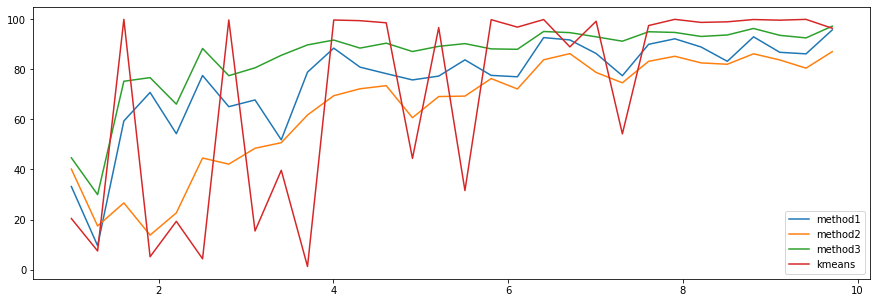

In [54]:
plt.figure(figsize=(15,5))
plt.plot(tauList, methode1, label = 'method1')
plt.plot(tauList, methode2, label = 'method2')
plt.plot(tauList,methode3, label = 'method3')
plt.plot(tauList,kmeansError, label = 'kmeans')
plt.legend()
plt.show()

After changing the starting model, I notice that the k-means sometimes gives very good results with a relative error close to 10% when the other methods exceed 50% but it remains unstable. Moreover, the 3 other methods have more or less the same paces.

# Conclusion

Finally, method 1 studying the moment when $\hat{Z}$ exceeds $\frac{1}{2}$ often gives the best results concerning the relative error on the tau found. Nevertheless, the two other methods give satisfactory results and it would be interesting to see if it is not possible to find another graphical method on $\hat{Z}$ which allows to surpass the classical method 1. Moreover, generally, the methods are quite stable and robust because they give results that do not vary too much when I change the model parameters.

In some cases, the k-means method gives very good results even if it remains very unstable. During this study, I noticed that the parameters a, b, $\tau$  and the arrival model have an impact on the results but the way the process N has been drawn also influences the results. 

Concerning, the k-means I think I can still improve the results by changing the data representation and the calculation of the change rank. 

Moreover, it would be interesting to take the average $\tau$ between these 4 methods to see if the result could be improved.